In [31]:
import functools
import sys
import math
import scipy.io
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

import Test_Likelihood as tl
import ODE_Dynamics as od
import Positive_Symptom_fn as fn

from functools import partial

import scipy.stats as ss

tfd = tfp.distributions
tfb = tfp.bijectors

In [50]:
# Load Data
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
full_data = np.reshape(
      x, x.shape)
full_data = tf.transpose(full_data)
sliced_data = full_data[10:20,:]
print(sliced_data)

tf.Tensor(
[[  10. 1049.    7.]
 [  11. 1001.    8.]
 [  12.  974.    6.]
 [  13.  950.    9.]
 [  14.  947.    8.]
 [  15.  974.    8.]
 [  16. 1003.   10.]
 [  17. 1028.    9.]
 [  18. 1014.   11.]
 [  19. 1026.   12.]], shape=(10, 3), dtype=float32)


In [51]:
# Arrange data in workable format
days = [float(i) for i in list(range(len(sliced_data)))]
tests = sliced_data[:,1]
positives = sliced_data[:,2]
test_data = np.column_stack((days, tests, positives))
test_data = tf.cast(test_data, dtype = tf.float32)
print(test_data)

tf.Tensor(
[[0.000e+00 1.049e+03 7.000e+00]
 [1.000e+00 1.001e+03 8.000e+00]
 [2.000e+00 9.740e+02 6.000e+00]
 [3.000e+00 9.500e+02 9.000e+00]
 [4.000e+00 9.470e+02 8.000e+00]
 [5.000e+00 9.740e+02 8.000e+00]
 [6.000e+00 1.003e+03 1.000e+01]
 [7.000e+00 1.028e+03 9.000e+00]
 [8.000e+00 1.014e+03 1.100e+01]
 [9.000e+00 1.026e+03 1.200e+01]], shape=(10, 3), dtype=float32)


In [52]:
    vdyn_ode_fn = od.ViralDynamics
    positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
    symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn
    prob_s_ibar = 0.1
    mu_b, sigma_b = 5, 1
    beta = np.random.normal(mu_b, sigma_b, 1)
    L = 0.0025/beta
    V0 = 1E3
    X0 = 1E6
    Y0 = V0
    par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
    vpar = par
    pospar = par
    sympar = par
    sample_size = 1000
    k = 1
    index = 1
    mu_b, sigma_b = 5, 1
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

    while index <= sample_size - 1:
        beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
        L = 0.0025/beta
        par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
        par = np.concatenate((par, par_new), axis = 0)
        V0 = np.random.normal(1E3, 1E2, 1)
        X0 = 1E6
        Y0 = V0
        init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
        init_state = np.concatenate((init_state, init_state_new), 0)

        index +=1
        

    vpar = tf.constant(par, dtype=tf.float32)
    pospar = par
    sympar = par


In [53]:
# Joint prior on nu, i, s
# nu ~ Beta(2,8), so that mode = 0.1
# i, s, (1-i-s) ~ Dirichlet(1,1,1)

joint_prior = tfd.JointDistributionNamed(dict(
    recov_rate = tfd.Beta(2,8),
    epi_state = tfd.Dirichlet(
    concentration = np.ones(2, np.float32)),
))

In [54]:
# Joint log prior
def joint_log_prior(nu, i, s):
    epi_state = [i,s]
    return joint_prior.log_prob(
      recov_rate = nu, epi_state = epi_state)

In [55]:
# Joint log-likelihood
# Prior on R0: 1/R0

def joint_log_prob(test_data, R0, nu, i, s):
    
    epipar = tf.constant(np.array([[R0, 5.0E-08, nu, i, s]], dtype=np.float32))

    loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 10.0, Epi_cadence=0.5, Vir_cadence=0.0625)
    ll,pp = loglike.__call__(test_data, epipar, vpar, pospar, sympar)
    ll = ll - math.log(R0) + joint_log_prior(nu,i,s).numpy()
    #+ math.log(ss.beta.pdf(nu,1,1))
    return ll


In [56]:
joint_log_prob(test_data, R0 = 1.8, nu = 0.1, i = 0.001, s = 0.999)

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=-574.19196>

In [8]:
# Compute log_lik 
# Impute things we don't want to sample, eg. observations

unnormalized_posterior_log_prob = partial(joint_log_prob, test_data)


In [9]:
# Initialize parameters

r0 = 1.8; nu0 = 0.1; i0 = 0.001; s0 = 0.999
initial_state = [r0, nu0, i0, s0]

In [10]:
# Transform all parameters so that parameter spaces are unconstrained
# Every parameter needs a bijector, might be 'Identity'

unconstraining_bijectors = [
    tfb.Log(),
    tfb.Invert(tfb.Sigmoid()),
    tfb.Invert(tfb.Sigmoid()),
    tfb.Invert(tfb.Sigmoid())
]

In [11]:
#@tf.function(autograph=False)
def sample():
    return tfp.mcmc.sample_chain(
        num_results = 1000,
        num_burnin_steps = 800,
        current_state = initial_state,
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn = unnormalized_posterior_log_prob,
                     step_size = 0.01,
                     num_leapfrog_steps = 2),
                bijector = unconstraining_bijectors),
             num_adaptation_steps = 700),
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [12]:
[R0, nu, i, s], is_accepted = sample()

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

In [13]:
# Compute posterior means of Epidemic parameters

acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_R0 = tf.reduce_mean(R0, axis=0).numpy()
mean_nu = tf.reduce_mean(nu, axis=0).numpy()
mean_i = tf.reduce_mean(i, axis=0).numpy()
mean_s = tf.reduce_mean(s, axis=0).numpy()


In [14]:
print('acceptance_rate:', acceptance_rate)
print('avg basic reproduction number:', mean_R0)
print('avg recovery rate:', mean_nu)
print('avg infected', mean_i)
print('avg susceptible', mean_s)

acceptance_rate: 0.583
avg basic reproduction number: 1.7974917
avg recovery rate: 0.040121615
avg infected 0.0025458795
avg susceptible 1.0910196


In [15]:
print(len(R0))
print(len(nu))
print(len(i))
print(len(s))

1000
1000
1000
1000


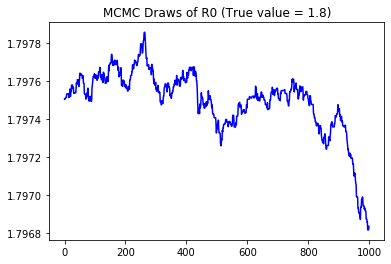

In [16]:
import matplotlib.pyplot as plt
t = list(range(len(R0)))
plt.plot(t, R0.numpy(), "b-")
plt.title("MCMC Draws of R0 (True value = 1.8)")
plt.savefig('mcmc_plot_R0.png', dpi=300, bbox_inches='tight')

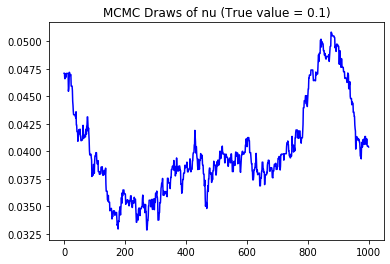

In [17]:
import matplotlib.pyplot as plt
t = list(range(len(nu)))
plt.plot(t, nu.numpy(), "b-")
plt.title("MCMC Draws of nu (True value = 0.1)")
plt.savefig('mcmc_plot_nu.png', dpi=300, bbox_inches='tight')